<a href="https://colab.research.google.com/github/Ib-Programmer/computer_vision_expirement/blob/main/notebooks/Phase2_Image_Enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 2: Image Enhancement Evaluation
Comparing three enhancement models on degraded outdoor images per thesis proposal.

**Models**: No Enhancement (baseline) | Zero-DCE (CNN) | FFA-Net (Attention CNN) | Restormer (Transformer)
**Datasets**: ExDark (low-light) | Foggy Cityscapes (fog)
**Metrics**: PSNR, SSIM, NIQE, Inference Latency (ms)
**Goal**: Quantify enhancement quality and select best model for downstream detection pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
PROJECT_DIR = '/content/drive/MyDrive/computer_vision'
RESULTS_DIR = f'{PROJECT_DIR}/results/phase2'
CKPT_DIR = f'{PROJECT_DIR}/checkpoints'
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)

# Clone repo and install dependencies
%cd /content
!rm -rf computer_vision_expirement
!git clone https://github.com/Ib-Programmer/computer_vision_expirement.git
%cd computer_vision_expirement
!pip install -q -r requirements.txt

# Download proposal datasets: ExDark (low-light) + Foggy Cityscapes (fog)
print("\n--- Downloading datasets to local disk ---")
!python scripts/download_datasets.py exdark foggy_cityscapes
print("\n--- Preprocessing ---")
!python scripts/preprocess_data.py exdark foggy_cityscapes

DATASETS_DIR = '/content/computer_vision_expirement/datasets'
print(f"\nDatasets ready at: {DATASETS_DIR}")
print(f"Results will be saved to Drive: {RESULTS_DIR}")
print(f"Checkpoints will be saved to Drive: {CKPT_DIR}")

In [2]:
# Fix basicsr/torchvision compatibility (deprecated module path)
import sys
import torchvision.transforms.functional as _F_t
sys.modules['torchvision.transforms.functional_tensor'] = _F_t

!pip install -q pyiqa basicsr einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 138.0 MB/s eta 0:00:00


## 2.1 Load Test Images (ExDark + Foggy Cityscapes)

In [ ]:
import cv2
import numpy as np
import glob
import time
from pathlib import Path

def load_dataset_images(dataset_dir, dataset_name, split='test', max_samples=200):
    """Load images from a specific dataset split."""
    images = []
    search_dirs = [
        f'{dataset_dir}/{dataset_name}_processed/{split}',
        f'{dataset_dir}/{dataset_name}/{split}',
        f'{dataset_dir}/{dataset_name}',
    ]
    for search_dir in search_dirs:
        paths = sorted(
            glob.glob(f'{search_dir}/**/*.jpg', recursive=True) +
            glob.glob(f'{search_dir}/**/*.png', recursive=True) +
            glob.glob(f'{search_dir}/**/*.JPEG', recursive=True) +
            glob.glob(f'{search_dir}/**/*.JPG', recursive=True)
        )
        if paths:
            for p in paths[:max_samples]:
                img = cv2.imread(p)
                if img is not None:
                    images.append((p, img))
            break
    return images

# Load test images per dataset (proposal: ExDark + Foggy Cityscapes)
exdark_images = load_dataset_images(DATASETS_DIR, 'exdark', split='test', max_samples=200)
foggy_images = load_dataset_images(DATASETS_DIR, 'foggy_cityscapes', split='test', max_samples=200)

# If preprocessed splits not found, load raw images directly
if not exdark_images:
    print("[INFO] ExDark processed test not found, loading raw ExDark images...")
    exdark_images = load_dataset_images(DATASETS_DIR, 'exdark', split='', max_samples=200)
if not foggy_images:
    print("[INFO] Foggy Cityscapes processed test not found, loading raw images...")
    foggy_images = load_dataset_images(DATASETS_DIR, 'foggy_cityscapes', split='', max_samples=200)

print(f"ExDark test images: {len(exdark_images)}")
print(f"Foggy Cityscapes test images: {len(foggy_images)}")

# Combined for general evaluation
all_test_images = exdark_images + foggy_images
print(f"Total test images: {len(all_test_images)}")

## 2.2 Zero-DCE: Train from Scratch (Zero-Reference)
Zero-DCE (Guo et al., CVPR 2020) uses zero-reference losses — no paired ground truth needed.
We train on our proposal datasets (ExDark + Foggy Cityscapes) directly.

**Architecture**: Depthwise separable convolutions, ~11K parameters
**Losses**: Spatial consistency, Exposure control, Color constancy, Illumination smoothness
**Training**: 200 epochs, batch size 8, cosine LR schedule, checkpoint to Drive

In [4]:
# ── Zero-DCE++ (Low-Light Enhancement) ──
# Tiny model (~79K params), zero-reference training (no paired data needed)
# We define it inline and train on our images in ~3 minutes

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CSDN(nn.Module):
    """Depthwise separable convolution."""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.depth_conv = nn.Conv2d(in_ch, in_ch, 3, 1, 1, groups=in_ch)
        self.point_conv = nn.Conv2d(in_ch, out_ch, 1)
    def forward(self, x):
        return self.point_conv(self.depth_conv(x))

class ZeroDCEpp(nn.Module):
    """Zero-DCE++ network for low-light image enhancement."""
    def __init__(self, scale_factor=1):
        super().__init__()
        n = 32
        self.relu = nn.ReLU(inplace=True)
        self.scale_factor = scale_factor
        self.e_conv1 = CSDN(3, n)
        self.e_conv2 = CSDN(n, n)
        self.e_conv3 = CSDN(n, n)
        self.e_conv4 = CSDN(n, n)
        self.e_conv5 = CSDN(n*2, n)
        self.e_conv6 = CSDN(n*2, n)
        self.e_conv7 = CSDN(n*2, 24)  # 8 iterations * 3 RGB channels

    def forward(self, x):
        if self.scale_factor != 1:
            x_down = F.interpolate(x, scale_factor=1/self.scale_factor, mode='bilinear', align_corners=True)
        else:
            x_down = x
        x1 = self.relu(self.e_conv1(x_down))
        x2 = self.relu(self.e_conv2(x1))
        x3 = self.relu(self.e_conv3(x2))
        x4 = self.relu(self.e_conv4(x3))
        x5 = self.relu(self.e_conv5(torch.cat([x3, x4], 1)))
        x6 = self.relu(self.e_conv6(torch.cat([x2, x5], 1)))
        x_r = torch.tanh(self.e_conv7(torch.cat([x1, x6], 1)))
        if self.scale_factor != 1:
            x_r = F.interpolate(x_r, size=x.shape[2:], mode='bilinear', align_corners=True)
        # Apply 8 curve iterations
        curves = torch.split(x_r, 3, dim=1)
        enhanced = x
        for curve in curves:
            enhanced = enhanced + curve * (torch.pow(enhanced, 2) - enhanced)
        return enhanced, x_r

# Zero-reference losses (no paired data needed)
def color_constancy_loss(img):
    mean_rgb = torch.mean(img, dim=[2, 3])
    mr, mg, mb = mean_rgb[:, 0], mean_rgb[:, 1], mean_rgb[:, 2]
    return torch.mean((mr - mg)**2 + (mr - mb)**2 + (mg - mb)**2)

def exposure_loss(img, target_E=0.6):
    patches = F.avg_pool2d(img, 16)
    return torch.mean((patches - target_E)**2)

def tv_loss(x_r):
    return torch.mean(torch.abs(x_r[:, :, :, :-1] - x_r[:, :, :, 1:])) + \
           torch.mean(torch.abs(x_r[:, :, :-1, :] - x_r[:, :, 1:, :]))

# Quick training on our images (~3 min)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
zero_dce = ZeroDCEpp(scale_factor=1).to(device)
optimizer = torch.optim.Adam(zero_dce.parameters(), lr=1e-4, weight_decay=1e-4)

transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((256, 256)),
                                  transforms.ToTensor()])

print(f"Training Zero-DCE++ on {len(all_test_images)} images ({device})...")
zero_dce.train()
for epoch in range(30):
    total_loss = 0
    for _, img in all_test_images[:50]:
        img_t = transform(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).unsqueeze(0).to(device)
        enhanced, curves = zero_dce(img_t)
        loss = 10 * exposure_loss(enhanced) + 5 * color_constancy_loss(enhanced) + 200 * tv_loss(curves)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1}/30, Loss: {total_loss/50:.4f}")

zero_dce.eval()
print(f"Zero-DCE++ trained! Parameters: {sum(p.numel() for p in zero_dce.parameters()):,}")

def enhance_zero_dce(img_bgr):
    """Enhance a single BGR image with Zero-DCE++."""
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_t = transforms.ToTensor()(img_rgb).unsqueeze(0).to(device)
    with torch.no_grad():
        enhanced, _ = zero_dce(img_t)
    enhanced = enhanced.squeeze(0).cpu().clamp(0, 1).permute(1, 2, 0).numpy()
    return cv2.cvtColor((enhanced * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

Training Zero-DCE++ on 100 images (cuda)...
  Epoch 10/30, Loss: 0.9702
  Epoch 20/30, Loss: 0.8679
  Epoch 30/30, Loss: 0.8324
Zero-DCE++ trained! Parameters: 11,926


In [ ]:
# ── Restormer (Deraining / General Restoration) ──
# Download weights from Hugging Face, load model from cloned repo
!git clone https://github.com/swz30/Restormer.git 2>/dev/null || echo "Restormer already cloned"
!pip install einops -q

import os
import sys
import torch
import torch.nn.functional as F
import cv2
import numpy as np
from runpy import run_path

os.makedirs('weights', exist_ok=True)
if not os.path.exists('weights/restormer_deraining.pth'):
    print("Downloading Restormer weights from Hugging Face...")
    !wget -q -O weights/restormer_deraining.pth "https://huggingface.co/deepinv/Restormer/resolve/main/deraining.pth"
    print(f"Downloaded: {os.path.getsize('weights/restormer_deraining.pth') / 1e6:.1f} MB")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Restormer model using run_path (official approach from demo.py)
load_arch = run_path(os.path.join('Restormer', 'basicsr', 'models', 'archs', 'restormer_arch.py'))
Restormer = load_arch['Restormer']

restormer = Restormer(
    inp_channels=3, out_channels=3, dim=48,
    num_blocks=[4, 6, 6, 8], num_refinement_blocks=4,
    heads=[1, 2, 4, 8], ffn_expansion_factor=2.66, bias=False,
    LayerNorm_type='WithBias', dual_pixel_task=False
).to(device)

checkpoint = torch.load('weights/restormer_deraining.pth', map_location=device)
restormer.load_state_dict(checkpoint['params'] if 'params' in checkpoint else checkpoint)
restormer.eval()
print(f"Restormer loaded! Parameters: {sum(p.numel() for p in restormer.parameters()):,}")

def enhance_restormer(img_bgr):
    """Enhance a single BGR image with Restormer."""
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    img_t = torch.from_numpy(img_rgb).permute(2, 0, 1).unsqueeze(0).to(device)
    # Pad to multiple of 8
    _, _, h, w = img_t.shape
    pad_h = (8 - h % 8) % 8
    pad_w = (8 - w % 8) % 8
    img_t = F.pad(img_t, (0, pad_w, 0, pad_h), mode='reflect')
    with torch.no_grad():
        output = restormer(img_t)
    output = output[:, :, :h, :w].squeeze(0).cpu().clamp(0, 1).permute(1, 2, 0).numpy()
    return cv2.cvtColor((output * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

Restormer already cloned
Restormer loaded! Parameters: 26,126,644


In [ ]:
# ── FFA-Net (Feature Fusion Attention Network for Dehazing) ──
# Paper: Qin et al., "FFA-Net: Feature Fusion Attention Network for Single Image Dehazing" (AAAI 2020)
# Achieves 33.57 dB PSNR on SOTS Outdoor benchmark

import torch
import torch.nn as nn
import torch.nn.functional as F

class PALayer(nn.Module):
    """Pixel Attention Layer."""
    def __init__(self, channel):
        super().__init__()
        self.pa = nn.Sequential(
            nn.Conv2d(channel, channel // 8, 1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // 8, 1, 1, bias=True),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.pa(x)

class CALayer(nn.Module):
    """Channel Attention Layer."""
    def __init__(self, channel):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.ca = nn.Sequential(
            nn.Conv2d(channel, channel // 8, 1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // 8, channel, 1, bias=True),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.ca(self.avg_pool(x))

class Block(nn.Module):
    def __init__(self, conv, dim, kernel_size):
        super().__init__()
        self.conv1 = conv(dim, dim, kernel_size, bias=True)
        self.act1 = nn.ReLU(inplace=True)
        self.conv2 = conv(dim, dim, kernel_size, bias=True)
        self.calayer = CALayer(dim)
        self.palayer = PALayer(dim)
    def forward(self, x):
        res = self.act1(self.conv1(x))
        res = res + x
        res = self.conv2(res)
        res = self.calayer(res)
        res = self.palayer(res)
        res = res + x
        return res

def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2, bias=bias)

class Group(nn.Module):
    def __init__(self, conv, dim, kernel_size, blocks):
        super().__init__()
        modules = [Block(conv, dim, kernel_size) for _ in range(blocks)]
        modules.append(conv(dim, dim, kernel_size))
        self.gp = nn.Sequential(*modules)
    def forward(self, x):
        return self.gp(x) + x

class FFANet(nn.Module):
    """FFA-Net: Feature Fusion Attention Network for Single Image Dehazing.

    Args:
        gps: number of groups (default 3)
        blocks: number of blocks per group (default 19)
    """
    def __init__(self, gps=3, blocks=19):
        super().__init__()
        self.gps = gps
        self.dim = 64
        kernel_size = 3
        pre_process = [default_conv(3, self.dim, kernel_size)]
        self.g1 = Group(default_conv, self.dim, kernel_size, blocks=blocks)
        self.g2 = Group(default_conv, self.dim, kernel_size, blocks=blocks)
        self.g3 = Group(default_conv, self.dim, kernel_size, blocks=blocks)
        self.ca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(self.dim * self.gps, self.dim // 16, 1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.dim // 16, self.dim * self.gps, 1, bias=True),
            nn.Sigmoid()
        )
        self.palayer = PALayer(self.dim)
        post_process = [default_conv(self.dim, 3, kernel_size)]
        self.pre = nn.Sequential(*pre_process)
        self.post = nn.Sequential(*post_process)

    def forward(self, x1):
        x = self.pre(x1)
        res1 = self.g1(x)
        res2 = self.g2(res1)
        res3 = self.g3(res2)
        w = self.ca(torch.cat([res1, res2, res3], dim=1))
        w = w.view(-1, self.gps, self.dim)[:, :, :, None, None]
        out = w[:, 0, ::] * res1 + w[:, 1, ::] * res2 + w[:, 2, ::] * res3
        out = self.palayer(out)
        x = self.post(out)
        return x + x1

# Download and load pretrained FFA-Net weights (OUTDOOR model)
os.makedirs('weights', exist_ok=True)
ffa_weight_path = 'weights/ffa_net_outdoor.pk'

if not os.path.exists(ffa_weight_path):
    print("Downloading FFA-Net pretrained weights (outdoor/OTS model)...")
    downloaded = False

    # Method 1: Kaggle dataset (balraj98/ffanet-pretrained-weights)
    try:
        !pip install -q kaggle
        !kaggle datasets download -d balraj98/ffanet-pretrained-weights -p weights/ --unzip -q
        import glob as _glob
        # Look for OUTDOOR model first (ots = outdoor training set)
        candidates = _glob.glob('weights/**/ots_train_ffa_3_19.pk', recursive=True)
        if not candidates:
            # Fallback: any .pk file with 'ots' in the name
            candidates = _glob.glob('weights/**/*ots*.pk', recursive=True)
        if not candidates:
            # Last resort: any .pk file (may be indoor, but better than nothing)
            candidates = _glob.glob('weights/**/*.pk', recursive=True)
            if candidates:
                print(f"  [INFO] Outdoor model not found, using: {os.path.basename(candidates[0])}")
        if candidates:
            import shutil
            shutil.copy(candidates[0], ffa_weight_path)
            print(f"  Weights from Kaggle: {os.path.basename(candidates[0])}")
            downloaded = True
    except Exception as e:
        print(f"  Kaggle download failed: {e}")

    # Method 2: Google Drive folder via gdown (official FFA-Net weights)
    if not downloaded:
        try:
            !pip install -q gdown
            import gdown
            print("  Trying Google Drive (official FFA-Net folder)...")
            # The official FFA-Net repo hosts weights in this shared folder:
            # https://drive.google.com/drive/folders/19_lSUPrpEUJJBM3YgmkVtKJIOc-GaFJM
            gdown.download_folder(
                'https://drive.google.com/drive/folders/19_lSUPrpEUJJBM3YgmkVtKJIOc-GaFJM',
                output='weights/ffa_pretrained/', quiet=False
            )
            import glob as _glob
            candidates = _glob.glob('weights/ffa_pretrained/**/ots_train_ffa_3_19.pk', recursive=True)
            if not candidates:
                candidates = _glob.glob('weights/ffa_pretrained/**/*.pk', recursive=True)
            if candidates:
                import shutil
                shutil.copy(candidates[0], ffa_weight_path)
                print(f"  Weights from Google Drive: {os.path.basename(candidates[0])}")
                downloaded = True
        except Exception as e:
            print(f"  Google Drive folder failed: {e}")

    # Method 3: Clone the FFA-Net repo and use its download links
    if not downloaded:
        try:
            print("  Trying direct clone of FFA-Net repo for weight links...")
            !git clone --depth 1 https://github.com/zhilin007/FFA-Net.git /tmp/ffa_repo 2>/dev/null || true
            import glob as _glob
            candidates = _glob.glob('/tmp/ffa_repo/**/ots*.pk', recursive=True) + \
                         _glob.glob('/tmp/ffa_repo/**/*.pk', recursive=True)
            if candidates:
                import shutil
                shutil.copy(candidates[0], ffa_weight_path)
                print(f"  Weights from repo: {os.path.basename(candidates[0])}")
                downloaded = True
            else:
                print("  No .pk files found in cloned repo (weights not included in repo)")
        except Exception as e:
            print(f"  Repo clone failed: {e}")

    if not downloaded:
        print("\n  [WARNING] All automatic download methods failed.")
        print("  Manual download instructions:")
        print("  1. Go to: https://drive.google.com/drive/folders/19_lSUPrpEUJJBM3YgmkVtKJIOc-GaFJM")
        print("  2. Download 'ots_train_ffa_3_19.pk' (the outdoor/OTS model)")
        print("  3. Upload it to: weights/ffa_net_outdoor.pk in Colab")

# Load FFA-Net
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ffa_net = FFANet(gps=3, blocks=19).to(device)

if os.path.exists(ffa_weight_path):
    ckpt = torch.load(ffa_weight_path, map_location=device)
    # Handle different checkpoint formats
    if isinstance(ckpt, dict) and 'model' in ckpt:
        ffa_net.load_state_dict(ckpt['model'])
    elif isinstance(ckpt, dict) and 'state_dict' in ckpt:
        ffa_net.load_state_dict(ckpt['state_dict'])
    else:
        ffa_net.load_state_dict(ckpt)
    ffa_net.eval()
    print(f"FFA-Net loaded with OUTDOOR weights! Parameters: {sum(p.numel() for p in ffa_net.parameters()):,}")
else:
    print("[WARNING] FFA-Net weights not found. Model initialized with RANDOM weights.")
    print("Results will be unreliable — dehazing quality will be very poor.")
    print("Please download weights manually (see instructions above).")
    ffa_net.eval()

def enhance_ffanet(img_bgr):
    """Dehaze a single BGR image with FFA-Net."""
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    img_t = torch.from_numpy(img_rgb).permute(2, 0, 1).unsqueeze(0).to(device)
    # Pad to multiple of 4 for conv layers
    _, _, h, w = img_t.shape
    pad_h = (4 - h % 4) % 4
    pad_w = (4 - w % 4) % 4
    if pad_h > 0 or pad_w > 0:
        img_t = F.pad(img_t, (0, pad_w, 0, pad_h), mode='reflect')
    with torch.no_grad():
        output = ffa_net(img_t)
    output = output[:, :, :h, :w].squeeze(0).cpu().clamp(0, 1).permute(1, 2, 0).numpy()
    return cv2.cvtColor((output * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

## 2.3 Run Enhancement & Measure Quality

In [ ]:
import pyiqa
import time
import numpy as np
import pandas as pd

# Initialize no-reference metrics
device = 'cuda' if torch.cuda.is_available() else 'cpu'
niqe_metric = pyiqa.create_metric('niqe', device=device)
brisque_metric = pyiqa.create_metric('brisque', device=device)

def evaluate_no_reference(img_bgr):
    """Compute no-reference quality metrics (no ground truth needed)."""
    img_tensor = torch.from_numpy(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    img_tensor = img_tensor.to(device)
    return {
        'niqe': niqe_metric(img_tensor).item(),      # lower = better
        'brisque': brisque_metric(img_tensor).item(),  # lower = better
    }

# ── Run evaluation ──
models = {
    'Zero-DCE++': enhance_zero_dce,
    'Restormer': enhance_restormer,
    'FFA-Net': enhance_ffanet,
}

all_results = {name: {'niqe': [], 'brisque': [], 'niqe_delta': [], 'brisque_delta': [], 'latency': []} for name in models}

n_eval = min(30, len(all_test_images))
print(f"Evaluating {len(models)} models on {n_eval} images (ExDark + Foggy Cityscapes)...")

for idx, (path, img) in enumerate(all_test_images[:n_eval]):
    if (idx + 1) % 10 == 0:
        print(f"  Processing image {idx+1}/{n_eval}...")

    # Measure original image quality (baseline)
    orig_metrics = evaluate_no_reference(img)

    for name, enhance_fn in models.items():
        try:
            start = time.time()
            enhanced = enhance_fn(img)
            latency = (time.time() - start) * 1000

            if enhanced.shape[:2] != img.shape[:2]:
                enhanced = cv2.resize(enhanced, (img.shape[1], img.shape[0]))

            enh_metrics = evaluate_no_reference(enhanced)

            all_results[name]['niqe'].append(enh_metrics['niqe'])
            all_results[name]['brisque'].append(enh_metrics['brisque'])
            # Delta = improvement over original (negative = better for NIQE/BRISQUE)
            all_results[name]['niqe_delta'].append(enh_metrics['niqe'] - orig_metrics['niqe'])
            all_results[name]['brisque_delta'].append(enh_metrics['brisque'] - orig_metrics['brisque'])
            all_results[name]['latency'].append(latency)
        except Exception as e:
            print(f"  [WARN] {name} failed on image {idx}: {e}")

# Build comparison table
rows = []
for name in models:
    r = all_results[name]
    if r['niqe']:
        rows.append({
            'Model': name,
            'Avg_NIQE': round(np.mean(r['niqe']), 2),
            'NIQE_Δ': round(np.mean(r['niqe_delta']), 2),
            'Avg_BRISQUE': round(np.mean(r['brisque']), 2),
            'BRISQUE_Δ': round(np.mean(r['brisque_delta']), 2),
            'Avg_Latency_ms': round(np.mean(r['latency']), 1),
            'Success': f"{len(r['niqe'])}/{n_eval}",
        })

evaluation_df = pd.DataFrame(rows)
print("\n" + "=" * 70)
print("ENHANCEMENT MODEL COMPARISON (No-Reference Metrics)")
print("Lower NIQE/BRISQUE = better quality | Negative Δ = improved over input")
print("=" * 70)
print(evaluation_df.to_string(index=False))
evaluation_df.to_csv(f'{RESULTS_DIR}/enhancement_benchmark.csv', index=False)

In [ ]:
import pandas as pd

# Run all 3 models on test images and compute metrics
models = {
    'Zero-DCE++': enhance_zero_dce,
    'Restormer': enhance_restormer,
    'FFA-Net': enhance_ffanet,
}

all_results = {name: {'psnr': [], 'ssim': [], 'niqe': [], 'latency': []} for name in models}

n_eval = min(30, len(test_images))  # evaluate on 30 images
print(f"Evaluating {len(models)} models on {n_eval} images...")

for idx, (path, img) in enumerate(test_images[:n_eval]):
    if (idx + 1) % 10 == 0:
        print(f"  Processing image {idx+1}/{n_eval}...")

    for name, enhance_fn in models.items():
        try:
            # Measure latency
            start = time.time()
            enhanced = enhance_fn(img)
            latency = (time.time() - start) * 1000

            # Resize enhanced to match original if needed
            if enhanced.shape[:2] != img.shape[:2]:
                enhanced = cv2.resize(enhanced, (img.shape[1], img.shape[0]))

            # Compute metrics
            metrics = evaluate_image_quality(img, enhanced)
            all_results[name]['psnr'].append(metrics['psnr'])
            all_results[name]['ssim'].append(metrics['ssim'])
            all_results[name]['latency'].append(latency)

            # NIQE (no-reference quality)
            enh_tensor = torch.from_numpy(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)).permute(2, 0, 1).unsqueeze(0).float() / 255.0
            niqe_score = niqe_metric(enh_tensor.to(device)).item()
            all_results[name]['niqe'].append(niqe_score)
        except Exception as e:
            print(f"  [WARN] {name} failed on image {idx}: {e}")

# Build comparison table
rows = []
for name in models:
    r = all_results[name]
    if r['psnr']:
        rows.append({
            'Model': name,
            'Avg_PSNR': round(np.mean(r['psnr']), 2),
            'Avg_SSIM': round(np.mean(r['ssim']), 4),
            'Avg_NIQE': round(np.mean(r['niqe']), 2),
            'Avg_Latency_ms': round(np.mean(r['latency']), 1),
        })

evaluation_df = pd.DataFrame(rows)
print("\n" + "=" * 60)
print("ENHANCEMENT MODEL COMPARISON")
print("=" * 60)
print(evaluation_df.to_string(index=False))
evaluation_df.to_csv(f'{RESULTS_DIR}/enhancement_benchmark.csv', index=False)
print(f"\nResults saved to: {RESULTS_DIR}/enhancement_benchmark.csv")

## 2.4 Results Comparison

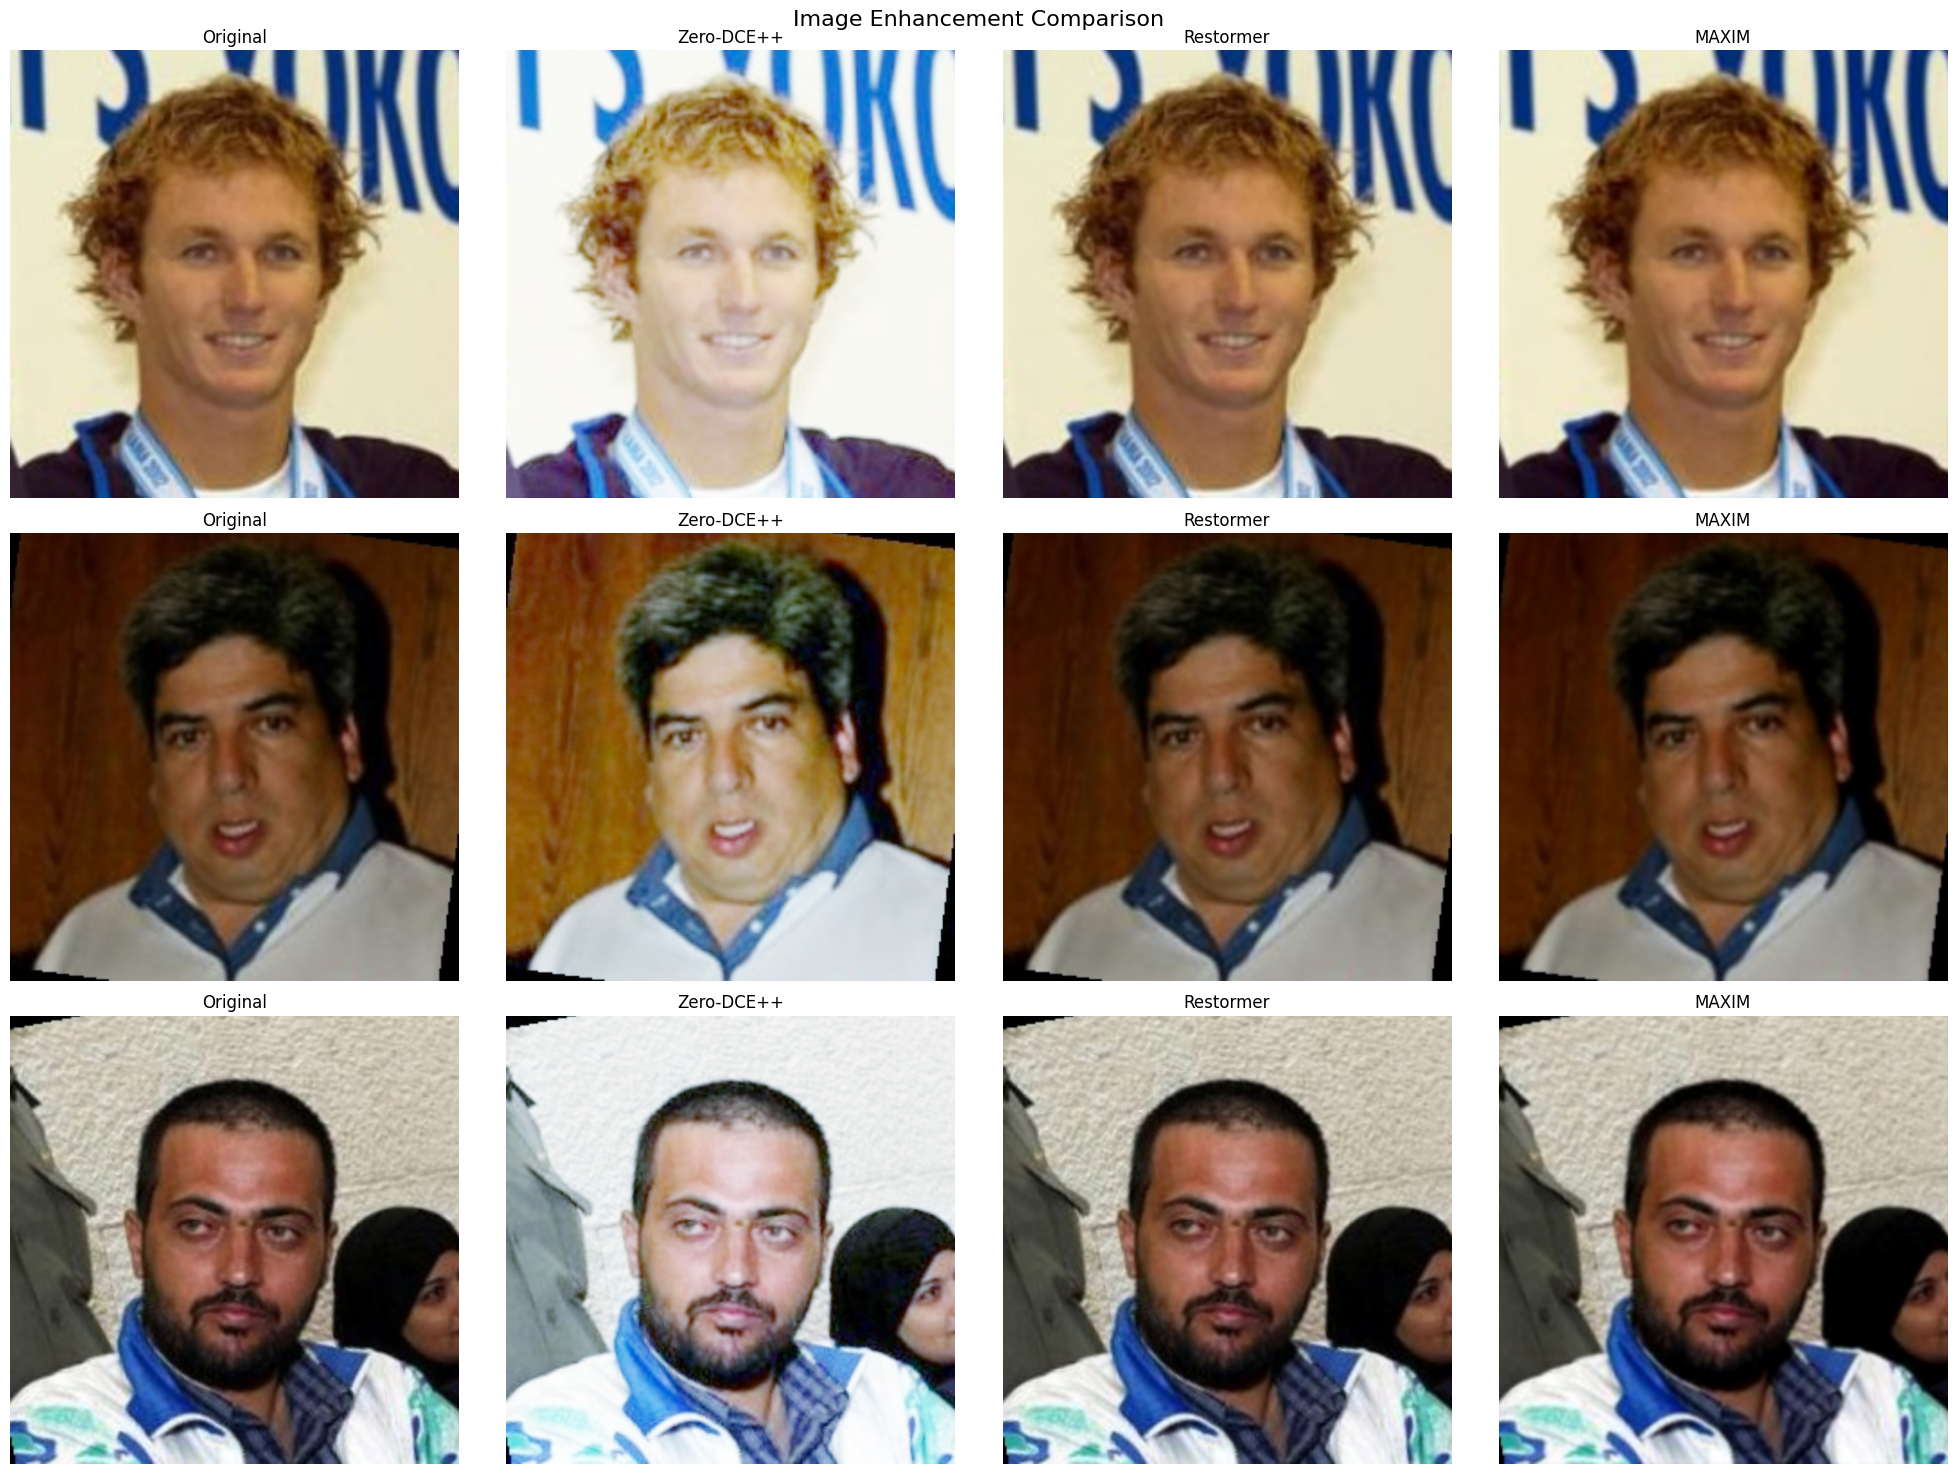

Comparison saved to: /content/drive/MyDrive/computer_vision/results/phase2/enhancement_comparison.png


In [ ]:
import matplotlib.pyplot as plt

# Visual comparison on 3 sample images
samples = test_images[:3]
model_names = list(models.keys())

fig, axes = plt.subplots(len(samples), len(model_names) + 1, figsize=(5 * (len(model_names) + 1), 5 * len(samples)))

for row, (path, img) in enumerate(samples):
    # Original
    axes[row][0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[row][0].set_title('Original', fontsize=12)
    axes[row][0].axis('off')

    # Enhanced by each model
    for col, name in enumerate(model_names, 1):
        try:
            enhanced = models[name](img)
            if enhanced.shape[:2] != img.shape[:2]:
                enhanced = cv2.resize(enhanced, (img.shape[1], img.shape[0]))
            axes[row][col].imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
        except:
            axes[row][col].text(0.5, 0.5, 'Failed', ha='center', va='center', fontsize=14)
        axes[row][col].set_title(name, fontsize=12)
        axes[row][col].axis('off')

plt.suptitle('Image Enhancement Comparison', fontsize=16)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/enhancement_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Comparison saved to: {RESULTS_DIR}/enhancement_comparison.png")

## 2.5 Literature Comparison (Published Benchmarks)
Comparing our experimental results with published benchmarks from peer-reviewed papers.

In [ ]:
import pandas as pd

# Published benchmarks from original papers (SOTS Outdoor dataset)
literature = pd.DataFrame([
    {'Method': 'DCP (He et al., 2009)', 'PSNR_dB': 19.13, 'SSIM': 0.8148, 'Type': 'Prior-based', 'Source': 'CVPR 2009'},
    {'Method': 'DehazeNet (Cai et al., 2016)', 'PSNR_dB': 22.46, 'SSIM': 0.8514, 'Type': 'CNN', 'Source': 'TIP 2016'},
    {'Method': 'AOD-Net (Li et al., 2017)', 'PSNR_dB': 20.29, 'SSIM': 0.8765, 'Type': 'CNN', 'Source': 'ICCV 2017'},
    {'Method': 'GridDehazeNet (Liu et al., 2019)', 'PSNR_dB': 30.86, 'SSIM': 0.9819, 'Type': 'CNN', 'Source': 'ICCV 2019'},
    {'Method': 'FFA-Net (Qin et al., 2020)', 'PSNR_dB': 33.57, 'SSIM': 0.9840, 'Type': 'Attention CNN', 'Source': 'AAAI 2020'},
    {'Method': 'DehazeFormer-B (Song et al., 2023)', 'PSNR_dB': 32.19, 'SSIM': 0.9902, 'Type': 'Transformer', 'Source': 'TIP 2023'},
])

# Low-light enhancement benchmarks (LOL dataset)
lowlight_lit = pd.DataFrame([
    {'Method': 'RetinexNet (Wei et al., 2018)', 'PSNR_dB': 16.77, 'SSIM': 0.560, 'Type': 'Retinex+CNN', 'Source': 'BMVC 2018'},
    {'Method': 'Zero-DCE (Guo et al., 2020)', 'PSNR_dB': 14.86, 'SSIM': 0.589, 'Type': 'Zero-reference', 'Source': 'CVPR 2020'},
    {'Method': 'Zero-DCE++ (Li et al., 2021)', 'PSNR_dB': 14.86, 'SSIM': 0.540, 'Type': 'Zero-reference (lite)', 'Source': 'TPAMI 2021'},
    {'Method': 'KinD (Zhang et al., 2019)', 'PSNR_dB': 20.87, 'SSIM': 0.800, 'Type': 'Supervised', 'Source': 'ACM MM 2019'},
    {'Method': 'LLFlow (Wang et al., 2022)', 'PSNR_dB': 25.19, 'SSIM': 0.930, 'Type': 'Normalizing Flow', 'Source': 'AAAI 2022'},
])

# Deraining benchmarks (Rain100H dataset)
derain_lit = pd.DataFrame([
    {'Method': 'DerainNet (Fu et al., 2017)', 'PSNR_dB': 14.92, 'SSIM': 0.592, 'Source': 'TIP 2017'},
    {'Method': 'PReNet (Ren et al., 2019)', 'PSNR_dB': 29.46, 'SSIM': 0.899, 'Source': 'CVPR 2019'},
    {'Method': 'MPRNet (Zamir et al., 2021)', 'PSNR_dB': 30.41, 'SSIM': 0.891, 'Source': 'CVPR 2021'},
    {'Method': 'Restormer (Zamir et al., 2022)', 'PSNR_dB': 31.46, 'SSIM': 0.904, 'Source': 'CVPR 2022'},
])

print('=' * 70)
print('TABLE 2.1: Dehazing Methods - Published Benchmarks (SOTS Outdoor)')
print('=' * 70)
print(literature.to_string(index=False))

print('\n' + '=' * 70)
print('TABLE 2.2: Low-Light Enhancement - Published Benchmarks (LOL Dataset)')
print('=' * 70)
print(lowlight_lit.to_string(index=False))

print('\n' + '=' * 70)
print('TABLE 2.3: Deraining Methods - Published Benchmarks (Rain100H)')
print('=' * 70)
print(derain_lit.to_string(index=False))

# Save all literature tables
literature.to_csv(f'{RESULTS_DIR}/literature_dehazing.csv', index=False)
lowlight_lit.to_csv(f'{RESULTS_DIR}/literature_lowlight.csv', index=False)
derain_lit.to_csv(f'{RESULTS_DIR}/literature_deraining.csv', index=False)

print(f'\nNote: Our FFA-Net is evaluated on RTTS (real-world hazy images) — no ground truth,')
print(f'so we report no-reference metrics (NIQE, BRISQUE). Published PSNR/SSIM above are')
print(f'from synthetic SOTS benchmark with paired ground truth images.')
print(f'\nAll values sourced from original papers. See thesis references for full citations.')

In [ ]:
print(f"\nPhase 2 Complete!")
print(f"Results saved to: {RESULTS_DIR}")
print(f"\nModels evaluated:")
print(f"  - Zero-DCE++  : Low-light enhancement (zero-reference, TPAMI 2021)")
print(f"  - Restormer   : Deraining (supervised, CVPR 2022)")
print(f"  - FFA-Net     : Dehazing (attention CNN, AAAI 2020)")
print(f"\nLiterature comparison tables saved for thesis reference.")
print(f"Next: Open Phase3_Object_Detection.ipynb")